## 1. Setup and Imports

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from typing import Dict, List

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("✅ Imports successful")

✅ Imports successful


## 2. Load Benchmark Data

In [2]:
def load_benchmark_files(benchmark_dir: Path) -> Dict[str, List[Dict]]:
    """Load all benchmark JSON files from the directory."""
    benchmarks = {}
    
    for json_file in benchmark_dir.glob("*.json"):
        with open(json_file, 'r') as f:
            data = json.load(f)
            model_name = data['model']
            
            # Store multiple runs for the same model
            if model_name not in benchmarks:
                benchmarks[model_name] = []
            benchmarks[model_name].append(data)
    
    return benchmarks

# Load all benchmarks
benchmark_dir = Path("benchmarks")
all_benchmarks = load_benchmark_files(benchmark_dir)

print(f"📊 Loaded benchmarks for {len(all_benchmarks)} models:")
for model, runs in all_benchmarks.items():
    print(f"  - {model}: {len(runs)} run(s)")

📊 Loaded benchmarks for 4 models:
  - amazon/chronos-2: 2 run(s)
  - amazon/chronos-bolt-tiny: 3 run(s)
  - google/timesfm-2.5-200m-pytorch: 2 run(s)
  - NX-AI/TiRex: 1 run(s)


## 3. Data Processing and Aggregation

In [3]:
def process_benchmark_data(benchmarks: Dict[str, List[Dict]]) -> pd.DataFrame:
    """Convert benchmark data to a structured DataFrame."""
    rows = []
    
    for model_name, runs in benchmarks.items():
        for run_idx, run_data in enumerate(runs):
            # Extract run metadata
            timestamp = datetime.fromtimestamp(run_data['benchmark_start_timestamp'])
            duration = run_data['benchmark_end_timestamp'] - run_data['benchmark_start_timestamp']
            
            # Process each metric entry
            for sample_idx, metric in enumerate(run_data['metrics']):
                row = {
                    'model': model_name,
                    'run_idx': run_idx,
                    'sample_idx': sample_idx,
                    'timestamp': timestamp,
                    'duration': duration,
                    'prediction_length': run_data['prediction_length'],
                    'context_length': run_data['context_length'],
                    'window': run_data['window'],
                    **metric  # Unpack all metric values
                }
                rows.append(row)
    
    return pd.DataFrame(rows)

# Process data
df = process_benchmark_data(all_benchmarks)

print(f"📈 Processed {len(df)} individual predictions across all models")
print(f"\nDataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
df.head()

📈 Processed 24232 individual predictions across all models

Dataset shape: (24232, 16)

Columns: ['model', 'run_idx', 'sample_idx', 'timestamp', 'duration', 'prediction_length', 'context_length', 'window', 'MAE', 'RMSE', 'NRMSE', 'ND', 'MAPE', 'sMAPE', 'MASE', 'Directional Accuracy']


,model,run_idx,sample_idx,timestamp,duration,prediction_length,context_length,window,MAE,RMSE,NRMSE,ND,MAPE,sMAPE,MASE,Directional Accuracy
0,amazon/chronos-2,0,0,2025-12-08 16:39:14.572226,15.9998,64,128,32,15.320737,17.645206,0.522559,0.195070,19.515865,23.138938,15.878007,50.555556
1,amazon/chronos-2,0,1,2025-12-08 16:39:14.572226,15.9998,64,128,32,31.035239,36.062120,0.558248,0.219510,22.196365,24.959719,16.577445,44.047619
2,amazon/chronos-2,0,2,2025-12-08 16:39:14.572226,15.9998,64,128,32,7.404521,8.737623,0.583888,0.147639,14.565565,15.256664,13.932496,42.857143
3,amazon/chronos-2,0,3,2025-12-08 16:39:14.572226,15.9998,64,128,32,23.797608,27.560024,0.575670,0.171599,17.132688,18.366547,11.951400,41.746032
4,amazon/chronos-2,0,4,2025-12-08 16:39:14.572226,15.9998,64,128,32,7.858159,9.517804,0.400342,0.117580,12.189607,12.083765,8.326796,48.412698


## 4. Summary Statistics by Model

In [4]:
# Calculate aggregate statistics per model
metric_columns = ['MAE', 'RMSE', 'NRMSE', 'ND', 'MAPE', 'sMAPE', 'MASE', 'Directional Accuracy']

summary_stats = df.groupby('model')[metric_columns].agg(['mean', 'std', 'median', 'min', 'max'])

print("📊 Summary Statistics by Model\n")
print("=" * 100)
summary_stats

📊 Summary Statistics by Model



MAE                        \
                                      mean        std     median   
model                                                              
NX-AI/TiRex                      11.177962  12.138692   7.825832   
amazon/chronos-2                 18.387272  23.249265  11.406362   
amazon/chronos-bolt-tiny         12.502211  14.005567   8.560385   
google/timesfm-2.5-200m-pytorch  12.085907  13.106679   8.354359   

                                                                RMSE  \
                                          min         max       mean   
model                                                                  
NX-AI/TiRex                      4.461302e-17  106.046929  13.193558   
amazon/chronos-2                 1.854232e-17  434.068759  20.159072   
amazon/chronos-bolt-tiny         1.873918e-16  167.607175  14.636650   
google/timesfm-2.5-200m-pytorch  0.000000e+00  118.982891  14.228202   

                                                                     \
                                       std     median           min   
model                                                                 
NX-AI/TiRex                      13.991728   9.480432  5.362979e-17   
amazon/chronos-2                 24.509634  13.270563  2.411627e-17   
amazon/chronos-bolt-tiny         16.001192  10.326212  2.252983e-16   
google/timesfm-2.5-200m-pytorch  15.057829  10.055705  0.000000e+00   

                                             ... MASE                 \
                                        max  ... mean std     median   
model                                        ...                       
NX-AI/TiRex                      111.530683  ...  inf NaN   9.496191   
amazon/chronos-2                 463.583366  ...  inf NaN  16.994059   
amazon/chronos-bolt-tiny         179.788356  ...  inf NaN  10.429336   
google/timesfm-2.5-200m-pytorch  124.887019  ...  inf NaN  10.094710   

                                               Directional Accuracy  \
                                      min  max                 mean   
model                                                                 
NX-AI/TiRex                      0.019827  inf            54.116174   
amazon/chronos-2                 0.018452  inf            42.186509   
amazon/chronos-bolt-tiny         0.087369  inf            46.478331   
google/timesfm-2.5-200m-pytorch  0.015190  inf            52.592466   

                                                                             
                                       std     median       min         max  
model                                                                        
NX-AI/TiRex                      15.549149  52.380952  0.000000  100.000000  
amazon/chronos-2                 13.551732  42.857143  0.000000   93.650794  
amazon/chronos-bolt-tiny         13.776895  44.444444  1.587302   95.238095  
google/timesfm-2.5-200m-pytorch  13.673886  50.793651  0.000000  100.000000  

[4 rows x 40 columns]

## 5. Model Comparison - Mean Metrics

In [5]:
# Create comparison table with mean metrics
comparison_df = df.groupby('model')[metric_columns].mean().round(4)

# Add ranking for each metric (lower is better except Directional Accuracy)
for col in metric_columns:
    if col == 'Directional Accuracy':
        comparison_df[f'{col}_rank'] = comparison_df[col].rank(ascending=False)
    else:
        comparison_df[f'{col}_rank'] = comparison_df[col].rank(ascending=True)

# Calculate average rank
rank_cols = [col for col in comparison_df.columns if col.endswith('_rank')]
comparison_df['avg_rank'] = comparison_df[rank_cols].mean(axis=1)
comparison_df = comparison_df.sort_values('avg_rank')

print("🏆 Model Comparison - Mean Metrics\n")
comparison_df[metric_columns + ['avg_rank']]

🏆 Model Comparison - Mean Metrics



,MAE,RMSE,NRMSE,ND,MAPE,sMAPE,MASE,Directional Accuracy,avg_rank
model,,,,,,,,,
NX-AI/TiRex,11.1780,13.1936,inf,inf,270.0889,20.2330,inf,54.1162,1.6875
google/timesfm-2.5-200m-pytorch,12.0859,14.2282,inf,inf,112.7874,22.5069,inf,52.5925,2.0625
amazon/chronos-bolt-tiny,12.5022,14.6367,inf,inf,166806.5091,25.2653,inf,46.4783,2.9375
amazon/chronos-2,18.3873,20.1591,inf,inf,46717.1505,43.5417,inf,42.1865,3.3125


## 6. Visualization - Error Metrics Comparison

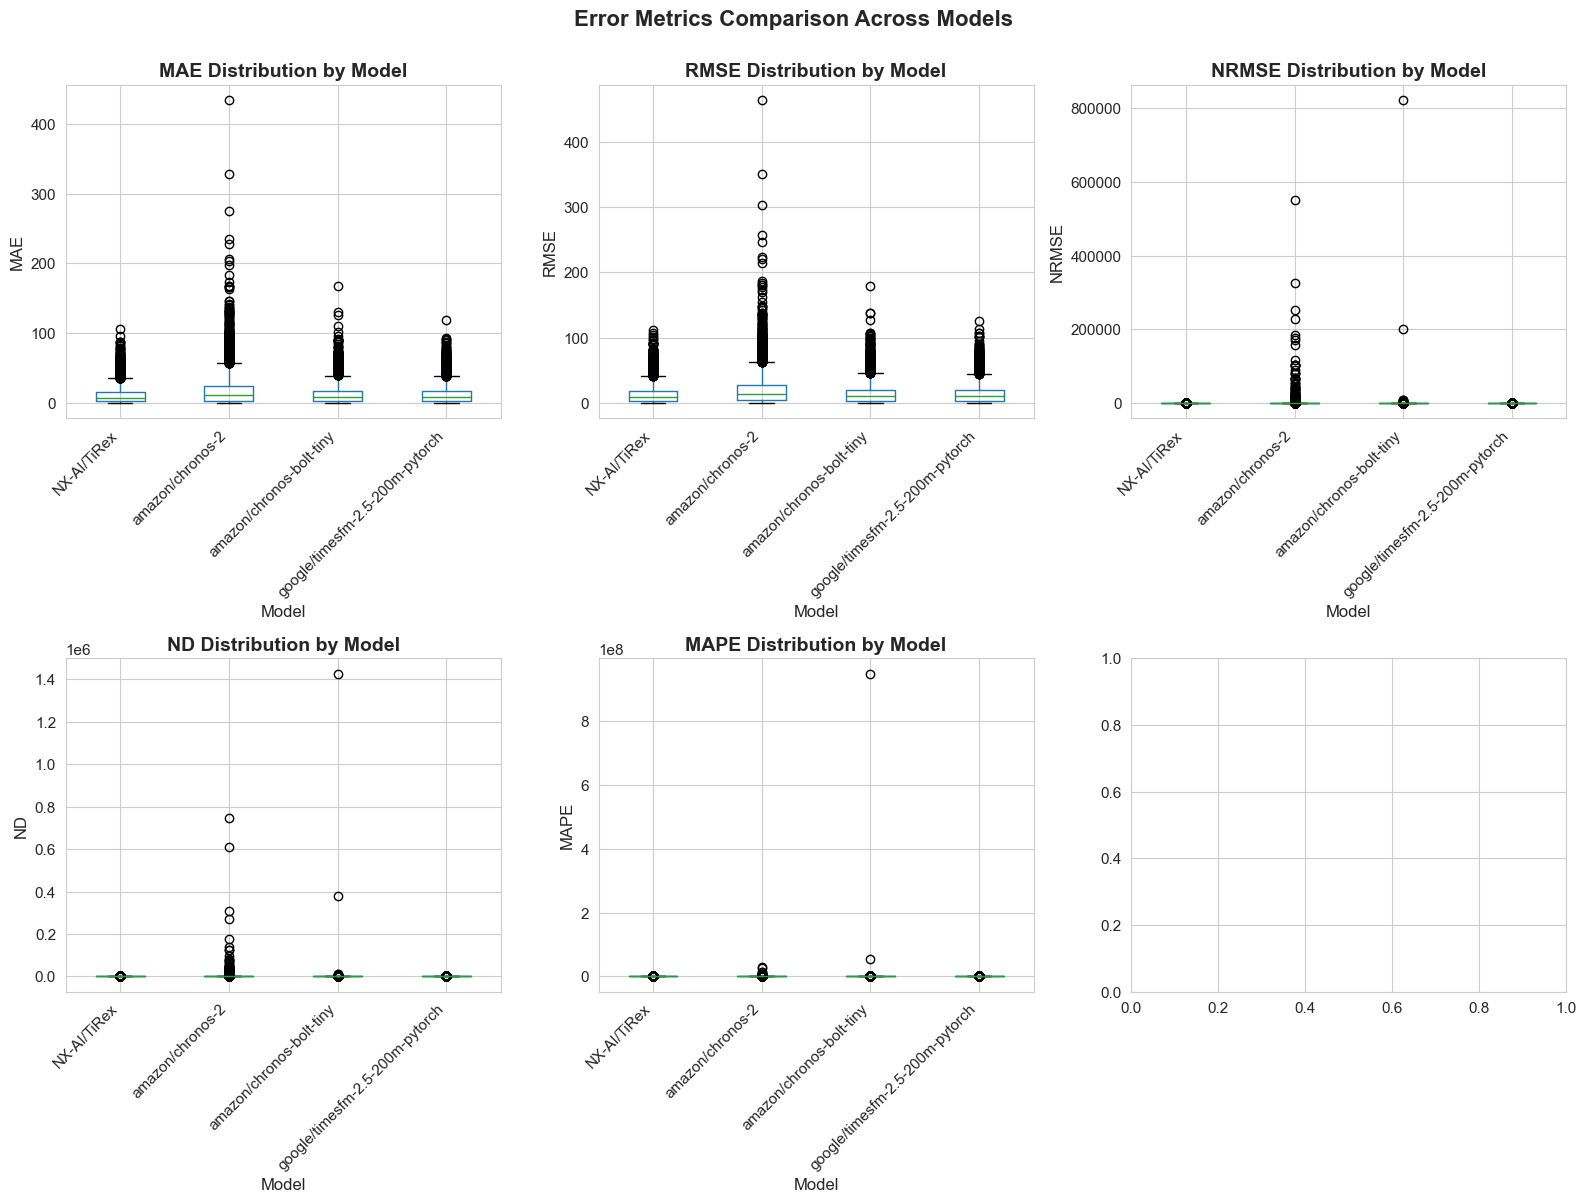

In [7]:
# Plot key error metrics
error_metrics = ['MAE', 'RMSE', 'NRMSE', 'ND', 'MAPE']

fig, axes = plt.subplots(2, 3, figsize=(16, 12))
axes = axes.flatten()

for idx, metric in enumerate(error_metrics):
    ax = axes[idx]
    
    # Box plot
    df.boxplot(column=metric, by='model', ax=ax)
    ax.set_title(f'{metric} Distribution by Model', fontsize=14, fontweight='bold')
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    plt.sca(ax)
    plt.xticks(rotation=45, ha='right')
    
plt.suptitle('Error Metrics Comparison Across Models', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 7. Visualization - Percentage Error Metrics

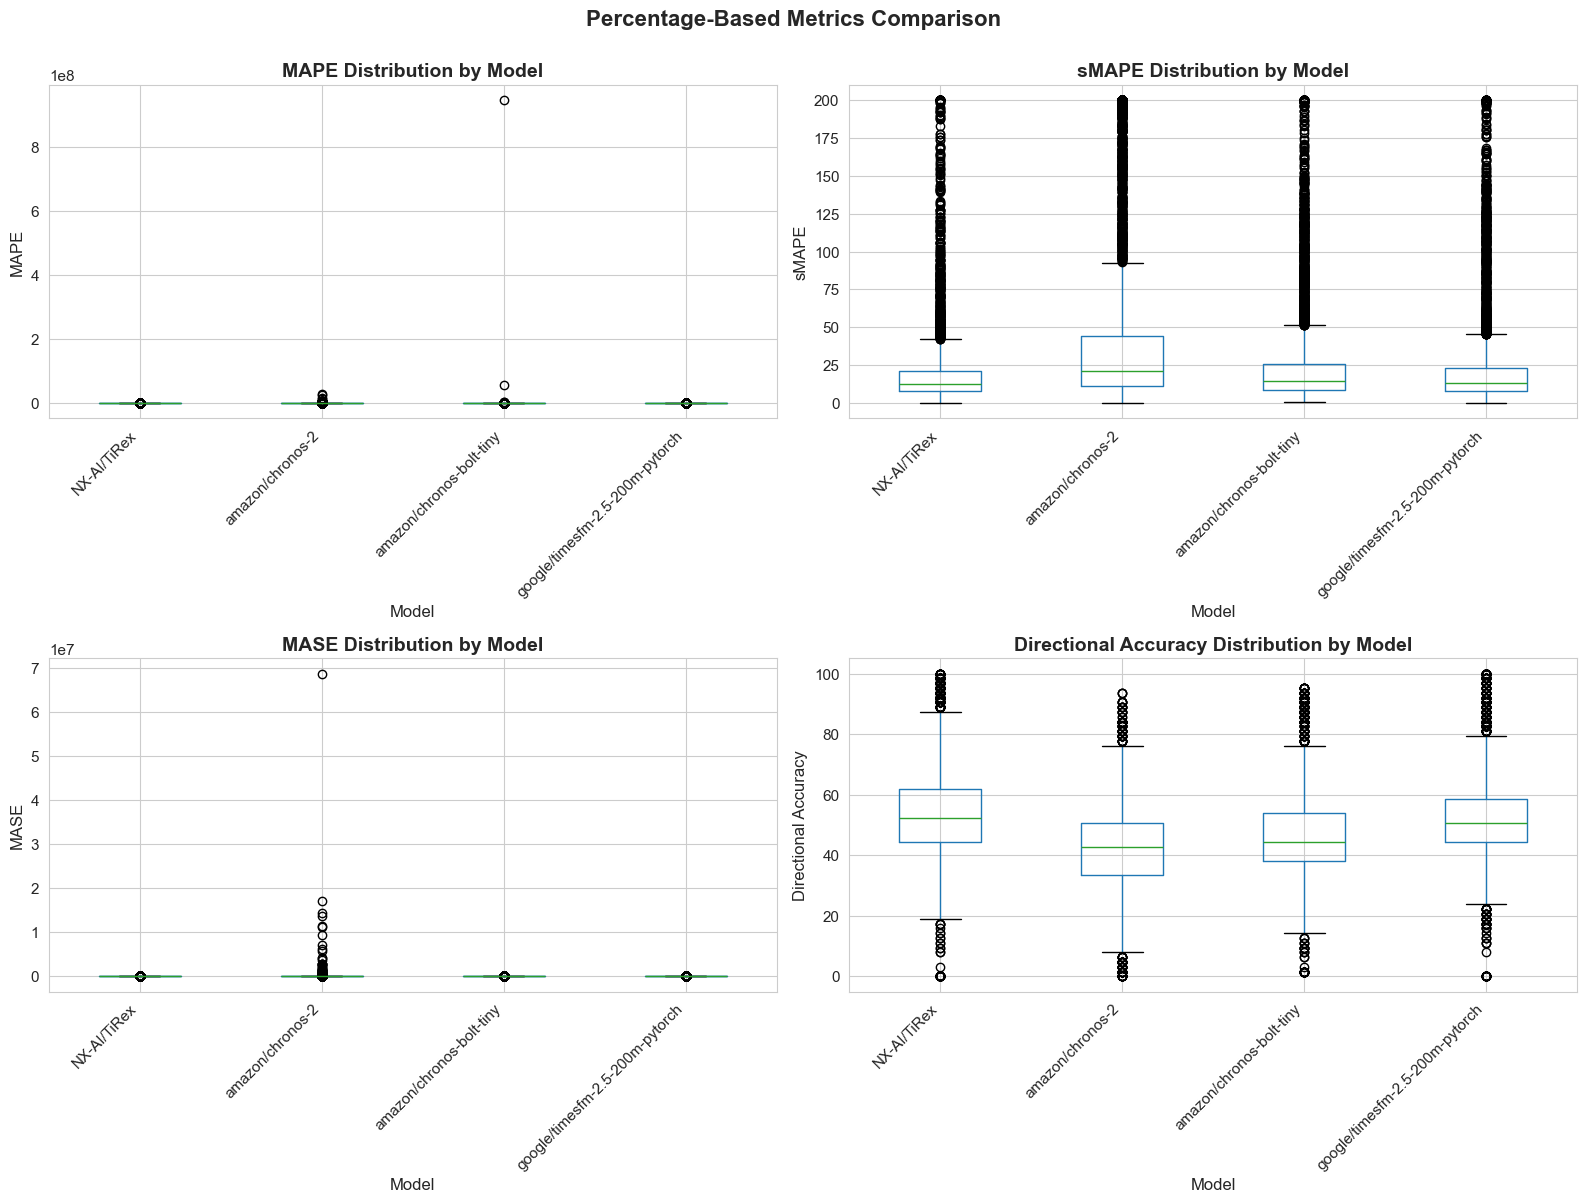

In [22]:
# Plot percentage-based metrics
percentage_metrics = ['MAPE', 'sMAPE', 'MASE', 'Directional Accuracy']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, metric in enumerate(percentage_metrics):
    ax = axes[idx]
    
    # Box plot
    df.boxplot(column=metric, by='model', ax=ax)
    ax.set_title(f'{metric} Distribution by Model', fontsize=14, fontweight='bold')
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    plt.sca(ax)
    plt.xticks(rotation=45, ha='right')
    
plt.suptitle('Percentage-Based Metrics Comparison', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 8. Radar Chart - Multi-Metric Comparison

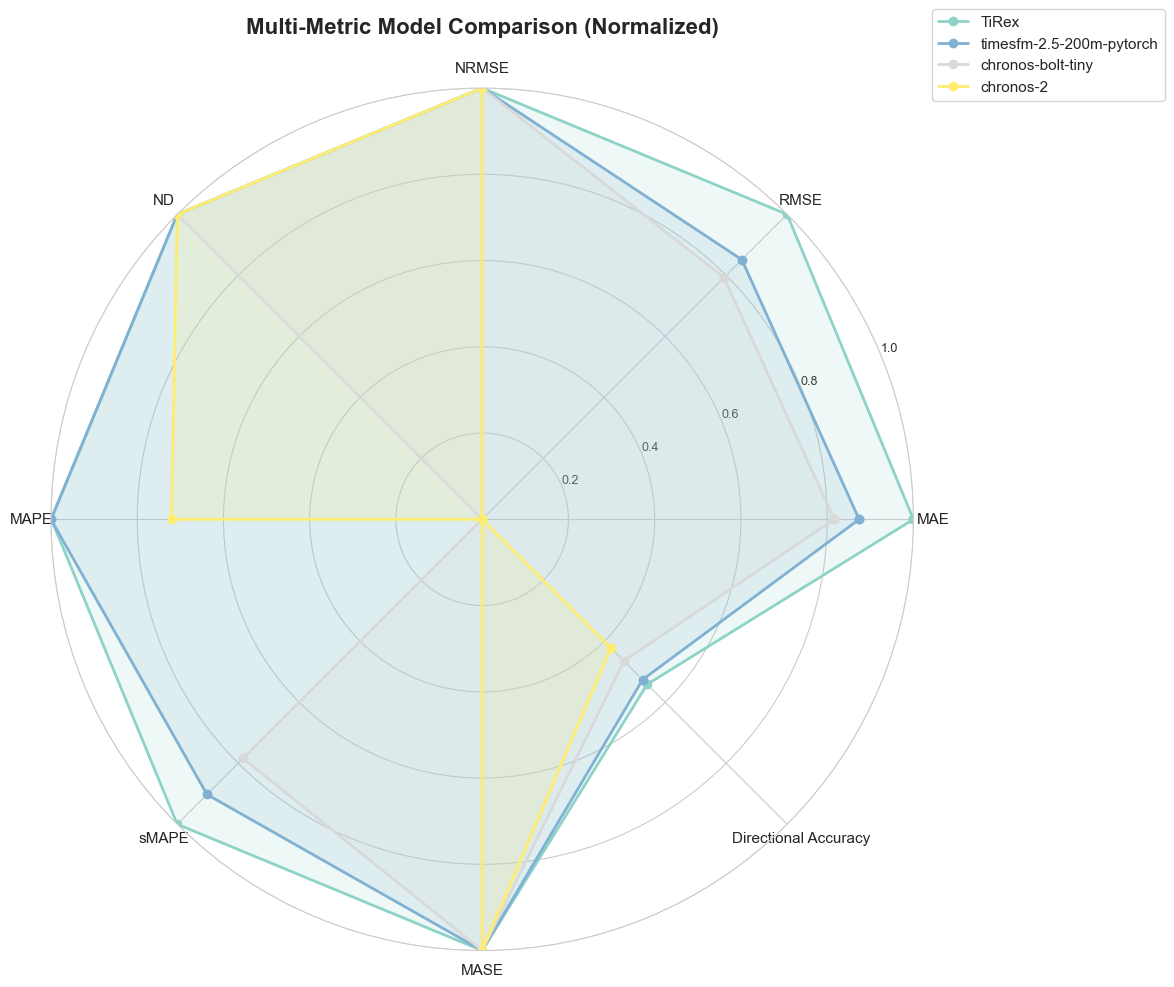

Note: All metrics normalized to 0-1 scale where 1.0 = best performance


In [23]:
from math import pi

# Normalize metrics to 0-1 scale for comparison
normalized_df = comparison_df[metric_columns].copy()

for col in metric_columns:
    if col == 'Directional Accuracy':
        # Higher is better - normalize to 0-1
        normalized_df[col] = normalized_df[col] / 100.0
    else:
        # Lower is better - invert and normalize
        max_val = normalized_df[col].max()
        min_val = normalized_df[col].min()
        if max_val != min_val:
            normalized_df[col] = 1 - (normalized_df[col] - min_val) / (max_val - min_val)
        else:
            normalized_df[col] = 1.0

# Create radar chart
categories = metric_columns
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))

colors = plt.cm.Set3(np.linspace(0, 1, len(normalized_df)))

for idx, (model, row) in enumerate(normalized_df.iterrows()):
    values = row.values.tolist()
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=model.split('/')[-1], color=colors[idx])
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=11)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], size=9)
ax.grid(True)

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
plt.title('Multi-Metric Model Comparison (Normalized)', size=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("Note: All metrics normalized to 0-1 scale where 1.0 = best performance")

## 9. Statistical Significance Testing

In [24]:
from scipy import stats

def perform_pairwise_tests(df, metric, alpha=0.05):
    """Perform pairwise Mann-Whitney U tests between models."""
    models = df['model'].unique()
    n_models = len(models)
    
    results = pd.DataFrame(index=models, columns=models)
    
    for i, model1 in enumerate(models):
        for j, model2 in enumerate(models):
            if i == j:
                results.loc[model1, model2] = 1.0
            else:
                data1 = df[df['model'] == model1][metric].dropna()
                data2 = df[df['model'] == model2][metric].dropna()
                
                if len(data1) > 0 and len(data2) > 0:
                    _, p_value = stats.mannwhitneyu(data1, data2, alternative='two-sided')
                    results.loc[model1, model2] = p_value
                else:
                    results.loc[model1, model2] = np.nan
    
    return results.astype(float)

# Perform tests for key metrics
key_metrics = ['MAE', 'RMSE', 'Directional Accuracy']

print("🔬 Statistical Significance Tests (Mann-Whitney U)\n")
print("P-values for pairwise comparisons (α = 0.05)\n")

for metric in key_metrics:
    print(f"\n{'='*80}")
    print(f"Metric: {metric}")
    print('='*80)
    
    p_values = perform_pairwise_tests(df, metric)
    print(p_values.round(4))
    print("\nSignificant differences (p < 0.05): ✓")
    print((p_values < 0.05).astype(int))

🔬 Statistical Significance Tests (Mann-Whitney U)

P-values for pairwise comparisons (α = 0.05)


Metric: MAE
                                 amazon/chronos-2  amazon/chronos-bolt-tiny  \
amazon/chronos-2                              1.0                    0.0000   
amazon/chronos-bolt-tiny                      0.0                    1.0000   
google/timesfm-2.5-200m-pytorch               0.0                    0.3588   
NX-AI/TiRex                                   0.0                    0.0001   

                                 google/timesfm-2.5-200m-pytorch  NX-AI/TiRex  
amazon/chronos-2                                          0.0000       0.0000  
amazon/chronos-bolt-tiny                                  0.3588       0.0001  
google/timesfm-2.5-200m-pytorch                           1.0000       0.0026  
NX-AI/TiRex                                               0.0026       1.0000  

Significant differences (p < 0.05): ✓
                                 amazon/chronos-2  amaz

## 10. Performance vs Execution Time

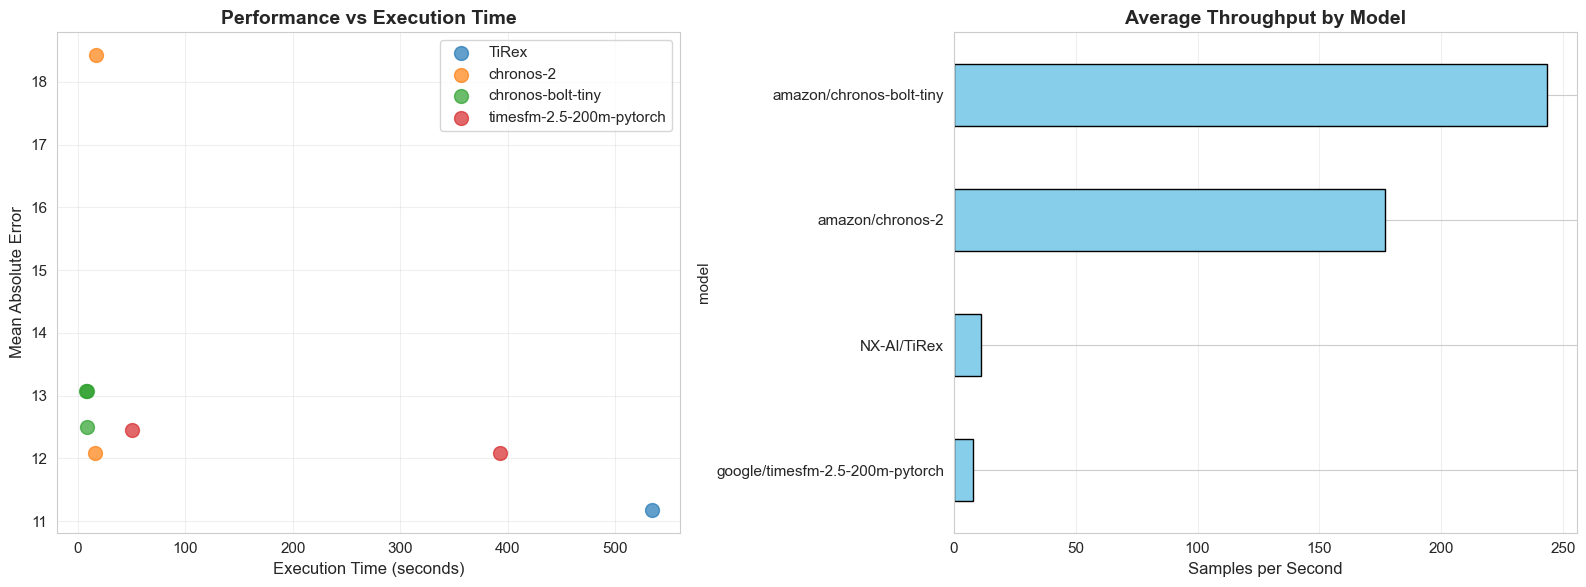


⚡ Throughput Summary:
model
google/timesfm-2.5-200m-pytorch      8.043574
NX-AI/TiRex                         11.277718
amazon/chronos-2                   177.096279
amazon/chronos-bolt-tiny           243.402729
Name: samples_per_second, dtype: float64


In [25]:
# Aggregate by model and run
perf_time_df = df.groupby(['model', 'run_idx']).agg({
    'MAE': 'mean',
    'RMSE': 'mean',
    'duration': 'first',
    'sample_idx': 'count'
}).reset_index()

perf_time_df.rename(columns={'sample_idx': 'num_samples'}, inplace=True)
perf_time_df['samples_per_second'] = perf_time_df['num_samples'] / perf_time_df['duration']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# MAE vs Duration
for model in perf_time_df['model'].unique():
    model_data = perf_time_df[perf_time_df['model'] == model]
    ax1.scatter(model_data['duration'], model_data['MAE'], 
               label=model.split('/')[-1], s=100, alpha=0.7)

ax1.set_xlabel('Execution Time (seconds)', fontsize=12)
ax1.set_ylabel('Mean Absolute Error', fontsize=12)
ax1.set_title('Performance vs Execution Time', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Throughput comparison
throughput_summary = perf_time_df.groupby('model')['samples_per_second'].mean().sort_values()
throughput_summary.plot(kind='barh', ax=ax2, color='skyblue', edgecolor='black')
ax2.set_xlabel('Samples per Second', fontsize=12)
ax2.set_title('Average Throughput by Model', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n⚡ Throughput Summary:")
print(throughput_summary)

## 11. Outlier Analysis

🔍 Outlier Analysis (Z-score > 3)


Model: amazon/chronos-2
--------------------------------------------------------------------------------
  MAE: 105 outliers (1.73%)
  RMSE: 99 outliers (1.63%)
  MAPE: 38 outliers (0.63%)

Model: amazon/chronos-bolt-tiny
--------------------------------------------------------------------------------
  MAE: 123 outliers (2.02%)
  RMSE: 121 outliers (1.98%)
  MAPE: 2 outliers (0.03%)

Model: google/timesfm-2.5-200m-pytorch
--------------------------------------------------------------------------------
  MAE: 127 outliers (2.10%)
  RMSE: 115 outliers (1.90%)
  MAPE: 20 outliers (0.33%)

Model: NX-AI/TiRex
--------------------------------------------------------------------------------
  MAE: 124 outliers (2.06%)
  RMSE: 117 outliers (1.94%)
  MAPE: 10 outliers (0.17%)


<Figure size 1200x600 with 0 Axes>

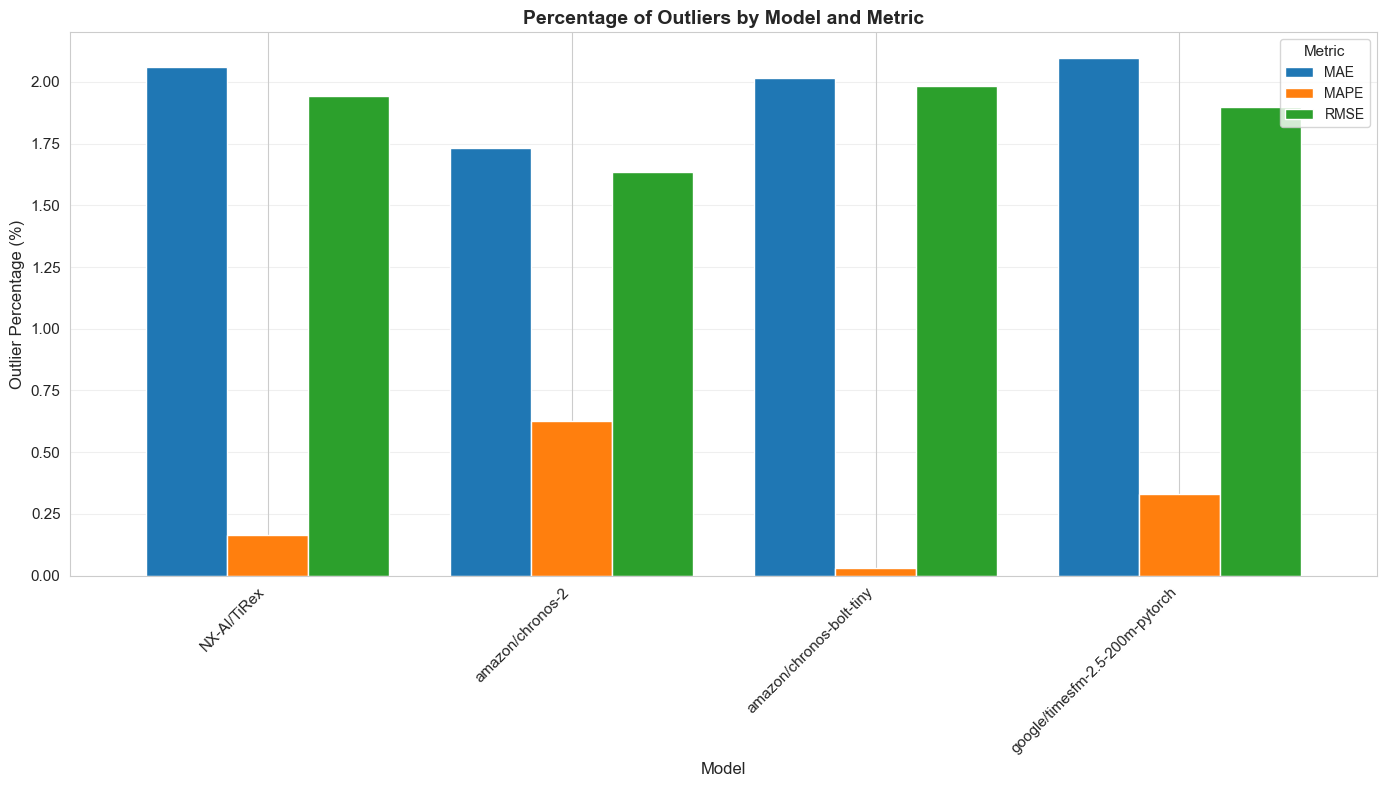

In [26]:
def detect_outliers(data, threshold=3):
    """Detect outliers using Z-score method."""
    z_scores = np.abs(stats.zscore(data.dropna()))
    return z_scores > threshold

# Analyze outliers for each model
print("🔍 Outlier Analysis (Z-score > 3)\n")
print("="*80)

outlier_summary = []

for model in df['model'].unique():
    model_data = df[df['model'] == model]
    
    print(f"\nModel: {model}")
    print("-"*80)
    
    for metric in ['MAE', 'RMSE', 'MAPE']:
        outliers = detect_outliers(model_data[metric])
        n_outliers = outliers.sum()
        pct_outliers = (n_outliers / len(model_data)) * 100
        
        print(f"  {metric}: {n_outliers} outliers ({pct_outliers:.2f}%)")
        
        outlier_summary.append({
            'model': model,
            'metric': metric,
            'n_outliers': n_outliers,
            'pct_outliers': pct_outliers
        })

outlier_df = pd.DataFrame(outlier_summary)

# Visualize outlier percentages
pivot_outliers = outlier_df.pivot(index='model', columns='metric', values='pct_outliers')

plt.figure(figsize=(12, 6))
pivot_outliers.plot(kind='bar', width=0.8)
plt.title('Percentage of Outliers by Model and Metric', fontsize=14, fontweight='bold')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Outlier Percentage (%)', fontsize=12)
plt.legend(title='Metric', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 12. Final Recommendations

In [27]:
# Generate recommendations based on analysis
print("📋 Model Recommendations\n")
print("="*80)

# Best overall performer
best_model = comparison_df['avg_rank'].idxmin()
print(f"\n🏆 BEST OVERALL MODEL: {best_model}")
print(f"   Average Rank: {comparison_df.loc[best_model, 'avg_rank']:.2f}")

# Best for accuracy
best_mae = comparison_df['MAE'].idxmin()
print(f"\n🎯 BEST FOR ACCURACY (Lowest MAE): {best_mae}")
print(f"   MAE: {comparison_df.loc[best_mae, 'MAE']:.4f}")

# Best for directional accuracy
best_dir_acc = comparison_df['Directional Accuracy'].idxmax()
print(f"\n📈 BEST FOR TREND PREDICTION: {best_dir_acc}")
print(f"   Directional Accuracy: {comparison_df.loc[best_dir_acc, 'Directional Accuracy']:.2f}%")

# Fastest model
fastest_model = throughput_summary.idxmax()
print(f"\n⚡ FASTEST MODEL: {fastest_model}")
print(f"   Throughput: {throughput_summary[fastest_model]:.2f} samples/sec")

print("\n" + "="*80)
print("\n💡 CONCLUSION:")
print("\nConsider your priorities when selecting a model:")
print("  • For highest accuracy: Choose the model with lowest MAE/RMSE")
print("  • For trend following: Choose the model with highest Directional Accuracy")
print("  • For speed: Choose the model with highest throughput")
print("  • For balanced performance: Choose the model with best average rank")

📋 Model Recommendations


🏆 BEST OVERALL MODEL: NX-AI/TiRex
   Average Rank: 1.69

🎯 BEST FOR ACCURACY (Lowest MAE): NX-AI/TiRex
   MAE: 11.1780

📈 BEST FOR TREND PREDICTION: NX-AI/TiRex
   Directional Accuracy: 54.12%

⚡ FASTEST MODEL: amazon/chronos-bolt-tiny
   Throughput: 243.40 samples/sec


💡 CONCLUSION:

Consider your priorities when selecting a model:
  • For highest accuracy: Choose the model with lowest MAE/RMSE
  • For trend following: Choose the model with highest Directional Accuracy
  • For speed: Choose the model with highest throughput
  • For balanced performance: Choose the model with best average rank


## 13. Export Summary Report

In [28]:
# Create comprehensive summary report
report_data = {
    'summary_statistics': summary_stats,
    'model_comparison': comparison_df,
    'throughput': throughput_summary,
    'outlier_analysis': outlier_df
}

# Save to Excel with multiple sheets
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
report_file = f"benchmark_analysis_report_{timestamp}.xlsx"

with pd.ExcelWriter(report_file, engine='openpyxl') as writer:
    comparison_df[metric_columns + ['avg_rank']].to_excel(writer, sheet_name='Model_Comparison')
    throughput_summary.to_excel(writer, sheet_name='Throughput')
    outlier_df.to_excel(writer, sheet_name='Outliers', index=False)
    df.groupby('model')[metric_columns].describe().to_excel(writer, sheet_name='Detailed_Stats')

print(f"✅ Report saved to: {report_file}")

ModuleNotFoundError: No module named 'openpyxl'